In [15]:
%matplotlib inline
import xarray as xr
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import h5pyd
import pandas as pd
import windrose as wr
import astral

In [2]:
import rex

In [3]:
from mmctools.helper_functions import theta
from mmctools.helper_functions import T_to_Tv
from mmctools.plotting import plot_timehistory_at_height, plot_profile, plot_timeheight

In [4]:
# constants
k = 0.4      # von Karman constant
g = 9.81
Rd = 287.05  # gas constant for dry air [J kg^-1 K-1]
Cp = 1004.   # specific heat at constant pressure for dry air [J kg^-1 K-1]

# WIND Toolkit Analysis (updated dataset)
# Part 2 - Seasonal Variability

Regis Thedin \
Dec 2020

## - Read saved feather files

In [5]:
df20km = pd.read_feather(os.path.join('data','df20km.ftr')).set_index(['datetime','height'])
dfsc = pd.read_feather(os.path.join('data','dfsc.ftr')).set_index(['datetime','height'])
df20km = pd.read_feather(os.path.join('data','df20km.ftr')).set_index(['datetime','height'])
dfold = pd.read_feather(os.path.join('data','dfold.ftr')).set_index(['datetime','height'])
dfcasp = pd.read_feather(os.path.join('data','dfcasp.ftr')).set_index(['datetime'])

## 5. Plots

### 5.1. Stability Classification Plots

In [6]:
Lgry = np.array([-50, -100, -200, -500, 500, 200, 50, 10])

# modifying so it's symmetric (following Eliot's early notebook)
Lranges = np.array([-0.5,-50, -200, -500, 500, 200, 50, 0.5])
zoverL_ranges = 2.0 / Lranges
zoverL_range_names = ['VU','U','NU','N','NS','S','VS']

In [7]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(18,7))

ax[0,0].set_title(r'old WTK, $z/L$, $z=2$ m', fontsize='x-large')
ax[0,1].set_title(r'single column, $z/L$, $z=2$ m', fontsize='x-large')
ax[0,2].set_title(r'20x20 km avg $z/L$, $z=2$ m', fontsize='x-large')

for i, df in enumerate([dfold,dfsc,df20km]):
    ax[0,i].hist(df['zoverL_2m'].xs(2,level='height'), bins=np.arange(-1, 8, 0.1))
    ax[0,i].set_ylabel('hours')
    ax[0,i].set_ylim([0,7000])
    
    ax[1,i].hist(df['zoverL_2m'].xs(2,level='height'), bins=np.arange(-0.3, 1, 0.02))
    ax[1,i].set_xlabel('z/L [-]');  ax[1,i].set_ylabel('hours')
    ax[1,i].set_ylim([0,2750]); ax[1,i].set_xlim([-0.3,1])


In [8]:
fig,ax = plt.subplots(nrows=1, ncols=3, figsize=(16,5))

fig.suptitle('Atmospheric Stability Classification (based on $z/L$, $z=2$)',fontsize='x-large')
ax[0].set_title(r'old WTK, $z/L$, $z=2$ m', fontsize='x-large')
ax[1].set_title(r'single column, $z/L$, $z=2$ m', fontsize='x-large')
ax[2].set_title(r'20x20 km avg $z/L$, $z=2$ m', fontsize='x-large')

for d, df in enumerate([dfold,dfsc,df20km]):
    counts = df['stability'].xs(0,level='height').value_counts()[zoverL_range_names]
    ax[d].bar(zoverL_range_names, counts)
    for i, h in enumerate(counts):
        ax[d].text(i,h+250,f'({Lranges[i]:g},{Lranges[i+1]:g}]',fontdict={'color':'r'},horizontalalignment='center')
    #ax[d].text(0.05,0.95,'$L$ bins indicated in red', verticalalignment='top', transform=ax[d].transAxes)
    ax[d].set_ylabel('hours')
    ax[d].grid(axis='y')


### 5.2. Heat flux distribution histograms


In [9]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(18,7))
fig.subplots_adjust(hspace=0.25)

fig.suptitle('heat flux',fontsize='x-large')
ax[0,0].set_title(r'old WTK, all states', fontsize='x-large')
ax[1,0].set_title(r'old WTK, U and VU states', fontsize='x-large')
ax[0,1].set_title(r'single column, all states', fontsize='x-large')
ax[1,1].set_title(r'single column, U and VU states', fontsize='x-large')
ax[0,2].set_title(r'20x20 km avg, all states', fontsize='x-large')
ax[1,2].set_title(r'20x20 km avg, U and VU states', fontsize='x-large')

for i,df in enumerate([dfold, dfsc,df20km]):
    # heat flux, all states
    heatfluxAll = df['hfx_Kms'].xs(0,level='height')
    # heat flux, U/VS states
    heatfluxU = df['hfx_Kms'].loc[(df['stability']=='U') | (df['stability']=='VU')].xs(0,level='height')

    ax[0,i].hist(heatfluxAll, bins=100)
    ax[0,i].set_ylabel('hours')

    ax[1,i].hist(heatfluxU, bins=100)
    ax[1,i].set_xlabel('heat flux [K-m/s]')
    ax[1,i].set_ylabel('hours')

### 5.3. Seasonal variability

In [31]:
# Aux variables for plotting
dfnames = ['old WTK','single column','20x20 km avg','KCPR airport']
season_names = ['Winter','Spring','Summer','Fall']
month_names = ['','Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# hours unique
hours_u = np.arange(0,24)

# heights where wind data are available for dfsc and df20km
heights_wind = np.concatenate((np.array([10]),np.arange(20,201,20)))

# hub height for wind roses
zhub = 80

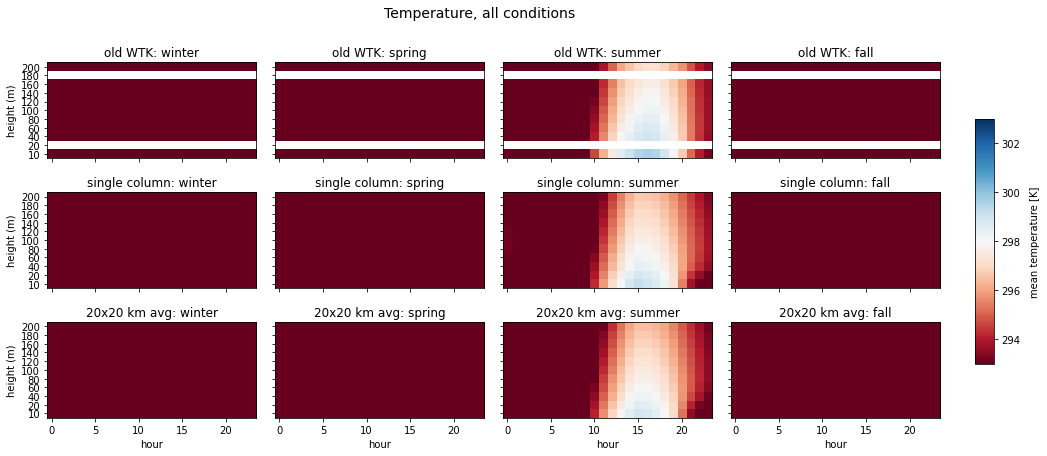

In [22]:
# Temperature over the seasons, at every height for every hour
fig, ax = plt.subplots(nrows=3, ncols=4, sharex=True, sharey=True, figsize=(16,6.8))
fig.suptitle('Temperature, all conditions',fontsize=14)
fig.subplots_adjust(hspace=0.18, wspace=0.09)
    
for d,df in enumerate([dfold,dfsc,df20km]):
    seasonaldata = df.groupby(['season','hour','height']).mean()
    for s in range(4):
        ws = np.zeros(shape=(len(heights_wind),len(hours_u)))
        for (i,z) in enumerate(heights_wind):
            for (j,h) in enumerate(hours_u): 
                try:
                    ws[i,j] = seasonaldata.loc[(s,h,z)]['temperature']    
                except KeyError:
                    ws[i,j] = np.nan
        p = ax[d,s].imshow(ws[:,:], origin='lower',vmin=273+20, vmax=273+30, cmap='RdBu')
        ax[d,s].set_title(f'{dfnames[d]}: {season_names[s]}')
        
    
# set titles, labels and colorbar
cb_ax = fig.add_axes([0.93,0.25, 0.017, 0.5]);  cbar = fig.colorbar(p, cax = cb_ax) 
cb_ax.set_ylabel('mean temperature [K]',labelpad=10)
for axi in ax[-1,:]:
    axi.set_xlabel('hour')
for axi in ax[:,0]:
    axi.set_ylabel('height (m)')
for axi in ax[1,:]:
    axi.set_yticks(np.linspace(0,10,11))
    axi.set_yticklabels(heights_wind)
    
plt.show()

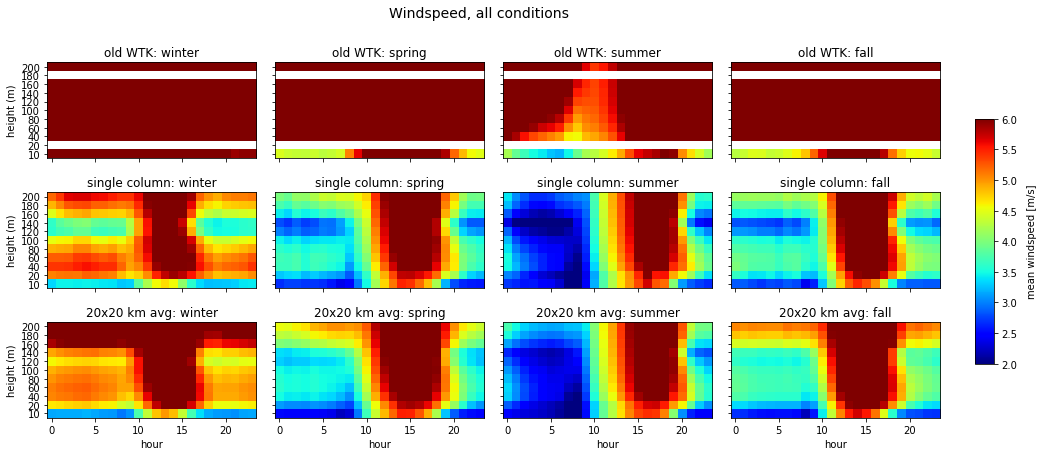

In [24]:
# Wind speed over the seasons, at every height for every hour
fig, ax = plt.subplots(nrows=3, ncols=4, sharex=True, sharey=True, figsize=(16,6.8))
fig.suptitle('Windspeed, all conditions',fontsize=14)
fig.subplots_adjust(hspace=0.18, wspace=0.09)
    
for d,df in enumerate([dfold,dfsc,df20km]):
    seasonaldata = df.groupby(['season','hour','height']).mean()
    for s in range(4):
        ws = np.zeros(shape=(len(heights_wind),len(hours_u)))
        for (i,z) in enumerate(heights_wind):
            for (j,h) in enumerate(hours_u): 
                try:
                    ws[i,j] = seasonaldata.loc[(s,h,z)]['windspeed']    
                except KeyError:
                    ws[i,j] = np.nan
        p = ax[d,s].imshow(ws[:,:], origin='lower',vmin=2, vmax=6, cmap='jet')
        ax[d,s].set_title(f'{dfnames[d]}: {season_names[s]}')
        
    
# set titles, labels and colorbar
cb_ax = fig.add_axes([0.93,0.25, 0.017, 0.5]);  cbar = fig.colorbar(p, cax = cb_ax) 
cb_ax.set_ylabel('mean windspeed [m/s]',labelpad=10)
for axi in ax[-1,:]:
    axi.set_xlabel('hour')
for axi in ax[:,0]:
    axi.set_ylabel('height (m)')
for axi in ax[1,:]:
    axi.set_yticks(np.linspace(0,10,11))
    axi.set_yticklabels(heights_wind)

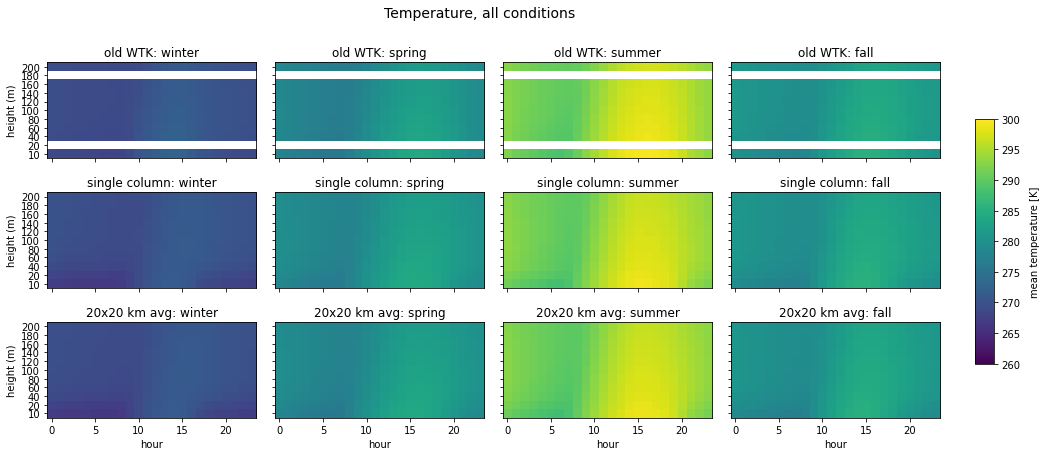

In [46]:
# Temperature over the seasons, at every height for every hour
fig, ax = plt.subplots(nrows=3, ncols=4, sharex=True, sharey=True, figsize=(16,6.8))
fig.suptitle('Temperature, all conditions',fontsize=14)
fig.subplots_adjust(hspace=0.18, wspace=0.09)
    
for d,df in enumerate([dfold,dfsc,df20km]):
    seasonaldata = df.groupby(['season','hour','height']).mean()
    for s in range(4):
        ws = np.zeros(shape=(len(heights_wind),len(hours_u)))
        for (i,z) in enumerate(heights_wind):
            for (j,h) in enumerate(hours_u): 
                try:
                    ws[i,j] = seasonaldata.loc[(s,h,z)]['temperature']    
                except KeyError:
                    ws[i,j] = np.nan
        p = ax[d,s].imshow(ws[:,:], origin='lower',vmin=260, vmax=300)
        ax[d,s].set_title(f'{dfnames[d]}: {season_names[s]}')
        
    
# set titles, labels and colorbar
cb_ax = fig.add_axes([0.93,0.25, 0.017, 0.5]);  cbar = fig.colorbar(p, cax = cb_ax) 
cb_ax.set_ylabel('mean temperature [K]',labelpad=10)
for axi in ax[-1,:]:
    axi.set_xlabel('hour')
for axi in ax[:,0]:
    axi.set_ylabel('height (m)')
for axi in ax[1,:]:
    axi.set_yticks(np.linspace(0,10,11))
    axi.set_yticklabels(heights_wind)

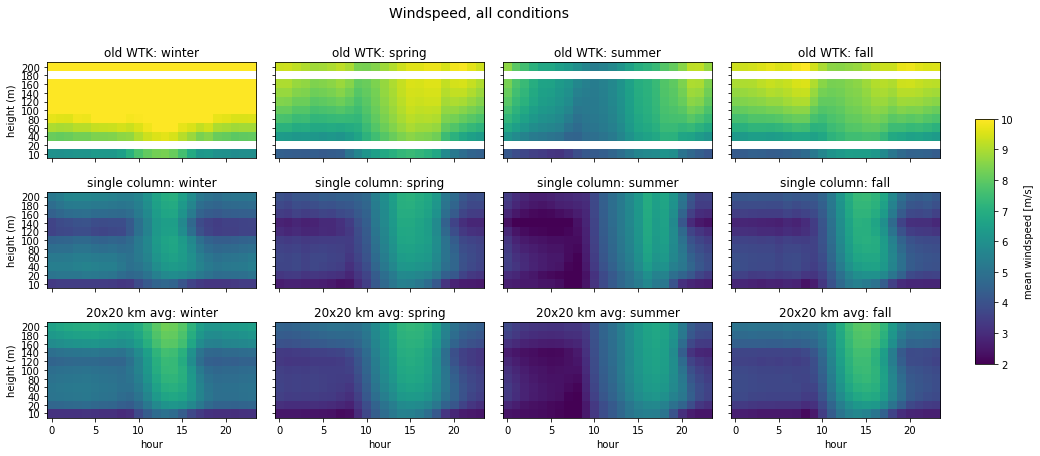

In [47]:
# Wind speed over the seasons, at every height for every hour
fig, ax = plt.subplots(nrows=3, ncols=4, sharex=True, sharey=True, figsize=(16,6.8))
fig.suptitle('Windspeed, all conditions',fontsize=14)
fig.subplots_adjust(hspace=0.18, wspace=0.09)
    
for d,df in enumerate([dfold,dfsc,df20km]):
    seasonaldata = df.groupby(['season','hour','height']).mean()
    for s in range(4):
        ws = np.zeros(shape=(len(heights_wind),len(hours_u)))
        for (i,z) in enumerate(heights_wind):
            for (j,h) in enumerate(hours_u): 
                try:
                    ws[i,j] = seasonaldata.loc[(s,h,z)]['windspeed']    
                except KeyError:
                    ws[i,j] = np.nan
        p = ax[d,s].imshow(ws[:,:], origin='lower',vmin=2, vmax=10)
        ax[d,s].set_title(f'{dfnames[d]}: {season_names[s]}')
        
    
# set titles, labels and colorbar
cb_ax = fig.add_axes([0.93,0.25, 0.017, 0.5]);  cbar = fig.colorbar(p, cax = cb_ax) 
cb_ax.set_ylabel('mean windspeed [m/s]',labelpad=10)
for axi in ax[-1,:]:
    axi.set_xlabel('hour')
for axi in ax[:,0]:
    axi.set_ylabel('height (m)')
for axi in ax[1,:]:
    axi.set_yticks(np.linspace(0,10,11))
    axi.set_yticklabels(heights_wind)

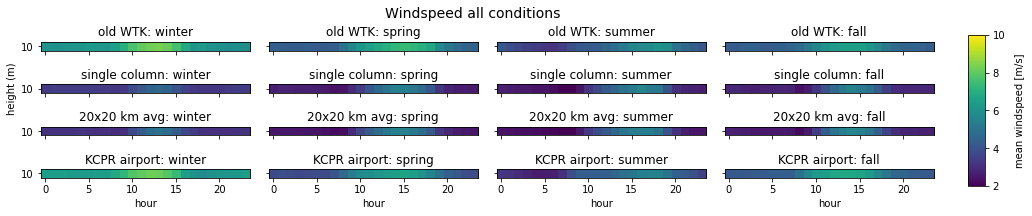

In [48]:
# Wind speed over the seasons, at every height for every hour
zcomp = 10

fig, ax = plt.subplots(nrows=4, ncols=4, sharex=True, sharey=True, figsize=(16,3))
fig.suptitle('Windspeed all conditions',fontsize=14)
fig.subplots_adjust(hspace=0.18, wspace=0.09)

for d,df in enumerate([dfold,dfsc,df20km]):
    seasonaldata = df.groupby(['season','hour','height']).mean()
    for s in range(4):
        ws = np.zeros(shape=(1,len(hours_u)))
        for (j,h) in enumerate(hours_u): 
            try:
                ws[0,j] = seasonaldata.loc[(s,h,zcomp)]['windspeed']    
            except KeyError:
                ws[0,j] = np.nan
        p = ax[d,s].imshow(ws[:,:], origin='lower',vmin=2, vmax=10)
        ax[d,s].set_title(f'{dfnames[d]}: {season_names[s]}')
        
# airport data (different format)
seasonaldata = dfcasp.groupby(['season','hour']).mean()
for s in range(4):
    ws = np.zeros(shape=(1,len(hours_u)))
    ws[0,:] = seasonaldata.loc[(s,slice(None))]['windspeed']
    ax[3,s].imshow(ws, origin='lower',vmin=2, vmax=10)
    ax[3,s].set_title(f'{dfnames[3]}: {season_names[s]}')

# set titles, labels and colorbar
cb_ax = fig.add_axes([0.93,0.15, 0.015, 0.7]);  cbar = fig.colorbar(p, cax = cb_ax) 
cb_ax.set_ylabel('mean windspeed [m/s]',labelpad=10)
for axi in ax[-1,:]:
    axi.set_xlabel('hour')
ax[1,0].set_ylabel('height (m)')
for axi in ax[:,-1]:
    axi.set_yticks([0])
    axi.set_yticklabels([zcomp])

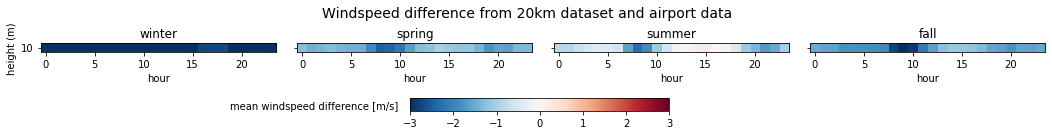

In [49]:
# Deviation of Wind speed from the airport data
fig, ax = plt.subplots(nrows=1, ncols=4, sharex=True, sharey=True, figsize=(18,1.2))
fig.suptitle('Windspeed difference from 20km dataset and airport data',fontsize=14)
fig.subplots_adjust(hspace=0.18, wspace=0.09)

seasonaldata20 = df20km.groupby(['season','hour','height']).mean()
seasonaldataWY = dfcasp.groupby(['season','hour']).mean()
for s in range(4):
    ws20 = np.zeros(shape=(1,len(hours_u)))
    wsWY = np.zeros(shape=(1,len(hours_u)))
    
    for (j,h) in enumerate(hours_u): 
        try:
            ws20[0,j] = seasonaldata20.loc[(s,h,zcomp)]['windspeed']    
        except KeyError:
            ws20[0,j] = np.nan
    wsWY[0,:] = seasonaldataWY.loc[(s,slice(None))]['windspeed']        

    p = ax[s].imshow(ws20-wsWY, origin='lower',vmin=-3, vmax=3, cmap='RdBu_r')
    
    ax[s].set_title(f'{season_names[s]}')

# set titles, labels and colorbar
cb_ax = fig.add_axes([0.41,-0.23,0.2, 0.15]);  cbar = fig.colorbar(p, cax = cb_ax, orientation='horizontal')
cb_ax.set_ylabel('mean windspeed difference [m/s]',labelpad=180, rotation=0, loc='bottom')
for axi in ax:
    axi.set_xlabel('hour')
ax[0].set_ylabel('height (m)')
for axi in ax[:]:
    axi.set_yticks([0])
    axi.set_yticklabels([zcomp])


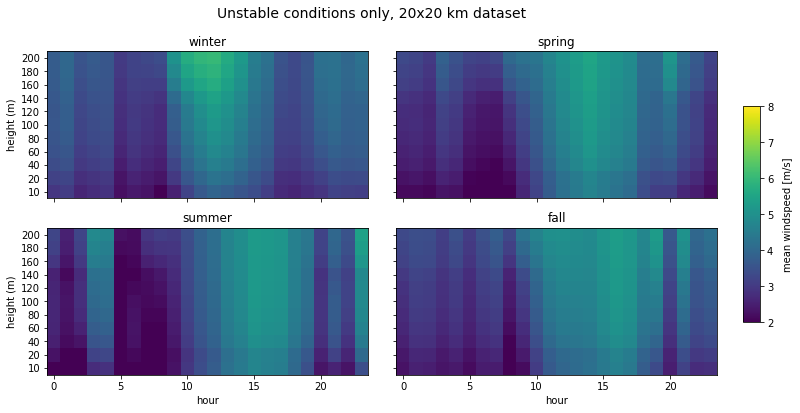

In [50]:
# Unstable only

fig, ax1 = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(12,6))
fig.suptitle('Unstable conditions only, 20x20 km dataset',fontsize=14)
fig.subplots_adjust(hspace=0.18, wspace=0.09)
ax=ax1.flatten()

for s in range(4):
    seasonaldataU = df20km.loc[(df20km['stability']=='U') | (df20km['stability']=='VU')].groupby(['season','hour','height']).mean()
    ws = np.zeros(shape=(len(heights_wind),len(hours_u)))
    for (i,z) in enumerate(heights_wind):
        for (j,h) in enumerate(hours_u): 
            ws[i,j] = seasonaldataU.loc[(s,h,z)]['windspeed']       
    p = ax[s].imshow(ws[:,:], origin='lower',vmin=2, vmax=8)
    ax[s].set_title(f'{season_names[s]}')
    
# set titles, labels and colorbar
cb_ax = fig.add_axes([0.93,0.25, 0.02, 0.5]);  cbar = fig.colorbar(p, cax = cb_ax) 
cb_ax.set_ylabel('mean windspeed [m/s]',labelpad=10)
for axi in ax1[-1,:]:
    axi.set_xlabel('hour')
for axi in ax1[:,0]:
    axi.set_ylabel('height (m)')
    axi.set_yticks(np.linspace(0,10,11))
    axi.set_yticklabels(heights_wind)

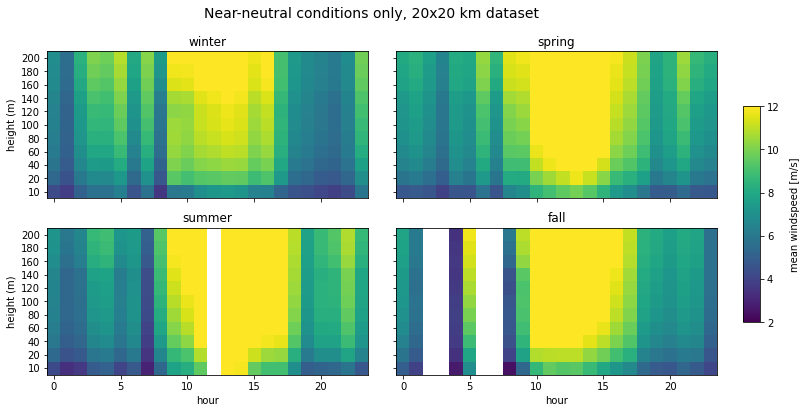

In [51]:
# only near-neutral
# missing data is because there is no conditions that match

fig, ax1 = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(12,6))
fig.suptitle('Near-neutral conditions only, 20x20 km dataset',fontsize=14)
fig.subplots_adjust(hspace=0.18, wspace=0.09)
ax=ax1.flatten()

for s in range(4):
    seasonaldataN = df20km.loc[df20km['stability']=='N'].groupby(['season','hour','height']).mean()
    ws = np.zeros(shape=(len(heights_wind),len(hours_u)))
    for (i,z) in enumerate(heights_wind):
        for (j,h) in enumerate(hours_u): 
            try:
                ws[i,j] = seasonaldataN.loc[(s,h,z)]['windspeed']    
            except KeyError:
                ws[i,j] = np.nan
                    
    p = ax[s].imshow(ws[:,:], origin='lower',vmin=2, vmax=12)
    ax[s].set_title(f'{season_names[s]}')
    
# set titles, labels and colorbar
cb_ax = fig.add_axes([0.93,0.25, 0.02, 0.5]);  cbar = fig.colorbar(p, cax = cb_ax) 
cb_ax.set_ylabel('mean windspeed [m/s]',labelpad=10)
for axi in ax1[-1,:]:
    axi.set_xlabel('hour')
for axi in ax1[:,0]:
    axi.set_ylabel('height (m)')
    axi.set_yticks(np.linspace(0,10,11))
    axi.set_yticklabels(heights_wind)

### 5.4. Daytime and nighttime wind roses
`windrose` convention for wind direction: northerly winds (from N to S) is 0 degrees, increase clockwise


In [25]:
# Auxiliary windrose plots variables
rec2x2 = [[0,0.5,0.4,0.4],[0.5,0.5,0.4,0.4],[0,0,0.4,0.4],[0.5,0,0.4,0.4]]
rec4x1 = [[0.00,0.00,0.22,1],[0.25,0.00,0.22,1],[0.50,0.00,0.22,1],[0.75,0.00,0.22,1]]
rec4x2 = [[0.00,0.50,0.22,0.45],[0.25,0.50,0.22,0.45],[0.50,0.50,0.22,0.45],[0.75,0.50,0.22,0.45],\
          [0.00,0.00,0.22,0.45],[0.25,0.00,0.22,0.45],[0.50,0.00,0.22,0.45],[0.75,0.00,0.22,0.45]]
rec4x4 = [[0.00,0.75,0.22,0.22],[0.25,0.75,0.22,0.22],[0.50,0.75,0.22,0.22],[0.75,0.75,0.22,0.22],\
          [0.00,0.50,0.22,0.22],[0.25,0.50,0.22,0.22],[0.50,0.50,0.22,0.22],[0.75,0.50,0.22,0.22],\
          [0.00,0.25,0.22,0.22],[0.25,0.25,0.22,0.22],[0.50,0.25,0.22,0.22],[0.75,0.25,0.22,0.22],\
          [0.00,0.00,0.22,0.22],[0.25,0.00,0.22,0.22],[0.50,0.00,0.22,0.22],[0.75,0.00,0.22,0.22]]

bins=([0,2,4,6,8,10,12,14])

wrlabels = ['','NE','','NW','','SW','','SE']

In [114]:
s=0
df20km.loc[(df20km['season']==s) & (df20km['hour']>=6) & (df20km['hour']<18)].xs(zhub, level='height')[['windspeed','winddirection']].describe()

,windspeed,winddirection
count,2160.000000,2160.000000
mean,5.972723,230.850477
std,3.092809,75.518726
min,0.361979,10.255521
25%,3.614271,234.283432
50%,5.592291,261.413177
75%,7.880105,271.309135
max,17.735521,349.685516


In [115]:
s=1
df20km.loc[(df20km['season']==s) & (df20km['hour']>=6) & (df20km['hour']<18)].xs(zhub, level='height')[['windspeed','winddirection']].describe()

,windspeed,winddirection
count,2208.000000,2208.000000
mean,5.210417,208.102557
std,3.428869,84.198298
min,0.533021,8.675625
25%,2.518750,128.947937
50%,4.411927,245.363739
75%,7.002995,268.700012
max,18.926561,354.373322


In [116]:
s=2
df20km.loc[(df20km['season']==s) & (df20km['hour']>=6) & (df20km['hour']<18)].xs(zhub, level='height')[['windspeed','winddirection']].describe()

,windspeed,winddirection
count,2208.000000,2208.000000
mean,4.381637,190.750808
std,3.230387,80.872570
min,0.368646,6.864271
25%,1.966510,122.552111
50%,3.449583,205.479156
75%,5.915157,261.637512
max,18.722813,345.381744


In [117]:
s=3
df20km.loc[(df20km['season']==s) & (df20km['hour']>=6) & (df20km['hour']<18)].xs(zhub, level='height')[['windspeed','winddirection']].describe()

,windspeed,winddirection
count,2184.000000,2184.000000
mean,5.510593,206.193559
std,3.567392,83.600969
min,0.390313,6.024167
25%,2.715729,127.978359
50%,4.733177,248.127342
75%,7.530469,265.601479
max,20.433437,353.738190


season 0:          windspeed  winddirection
count  2160.000000    2160.000000
mean      5.972723     230.850477
std       3.092809      75.518726
min       0.361979      10.255521
25%       3.614271     234.283432
50%       5.592291     261.413177
75%       7.880105     271.309135
max      17.735521     349.685516
season 1:          windspeed  winddirection
count  2208.000000    2208.000000
mean      5.210417     208.102557
std       3.428869      84.198298
min       0.533021       8.675625
25%       2.518750     128.947937
50%       4.411927     245.363739
75%       7.002995     268.700012
max      18.926561     354.373322
season 2:          windspeed  winddirection
count  2208.000000    2208.000000
mean      4.381637     190.750808
std       3.230387      80.872570
min       0.368646       6.864271
25%       1.966510     122.552111
50%       3.449583     205.479156
75%       5.915157     261.637512
max      18.722813     345.381744
season 3:          windspeed  winddirection
count  2

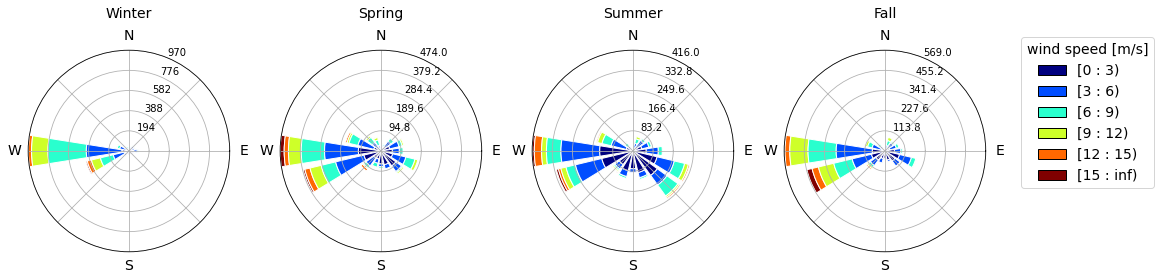

In [124]:
wrlabels = ['E','','N','','W','','S','']
bins=([0,3,6,9,12,15])

# Daytime, all conditions, at hub height
fig = plt.figure(figsize=(14,3.2))
#fig.suptitle('All conditions, at hub height, daytime (6AM–6PM)', y=1.025, fontsize=16)

rect = [[0.00,0.00,0.20,1],[0.25,0.00,0.20,1],[0.50,0.00,0.20,1],[0.75,0.00,0.20,1]]

for d,df in enumerate([df20km]):
    for s in range(4):
        wa = wr.WindroseAxes(fig, rect[d*4+s])
        fig.add_axes(wa)
        data = df.loc[(df['season']==s) & (df['hour']>=6) & (df['hour']<18)].xs(zhub, level='height') 
        ws = data['windspeed'].values
        wd = data['winddirection'].values
        
        aa=data[['windspeed','winddirection']]
        print(f'season {s}: {aa.describe()}')
        wa.bar(wd, ws, bins=bins, opening=0.8, edgecolor='white')
        wa.set_xticklabels(wrlabels, fontsize=14)
#         if s==0:
#             wa.set_yticks([14,30,45])
#             wa.set_yticklabels(['15%','30%','45%'], fontsize=13)
#         else:
#             wa.set_yticks([10,20,30])
#             wa.set_yticklabels(['10%','20%','30%'], fontsize=13)
            
        #wa.yaxis.set_major_locator(MaxNLocator(integer=True))
        if d==0: wa.set_title(f'{season_names[s]}',fontsize=14, y=1.13)
        #if s==0: wa.set_ylabel(f'{dfnames[d]}', fontsize=14, labelpad=10)

#wa.legend(loc='lower right',decimal_places=0,labelspacing=0.7,bbox_to_anchor=(0.25,-0.2),ncol=len(bins), title='wind speed [m/s]')
leg = wa.legend(loc='upper left', bbox_to_anchor=(1.14, 1.1),decimal_places=0, title='wind speed [m/s]', fontsize=14)
plt.setp(leg.get_title(),fontsize=14)

plt.show()
#fig.savefig(os.path.join('/scratch/rthedin/forRimple', 'windrose_percentage_season.png'), bbox_inches='tight', dpi=400)

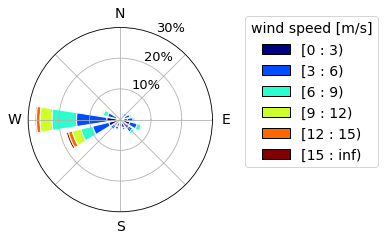

In [98]:
wrlabels = ['E','','N','','W','','S','']
bins=([0,3,6,9,12,15])

# Daytime, all conditions, at hub height, all year
fig = plt.figure(figsize=(3.3,3.2))

wa = wr.WindroseAxes.from_ax(fig=fig)
data = df20km.loc[(df20km['hour']>=6) & (df20km['hour']<18)].xs(zhub, level='height') 
ws = data['windspeed'].values
wd = data['winddirection'].values   
wa.bar(wd, ws, bins=bins, opening=0.8, edgecolor='white',normed=True)
wa.set_xticklabels(wrlabels, fontsize=14)
wa.set_yticks([10,20,30])
wa.set_yticklabels(['10%','20%','30%'], fontsize=13)
#wa.set_yticklabels([500,1000,1500,2000,2500])

leg = wa.legend(loc='upper left', bbox_to_anchor=(1.14, 1.1),decimal_places=0, title='wind speed [m/s]', fontsize=14)
plt.setp(leg.get_title(),fontsize=14)

plt.show()
fig.savefig(os.path.join('/scratch/rthedin/forRimple', 'windrose_percentage_year.png'), bbox_inches='tight', dpi=400)

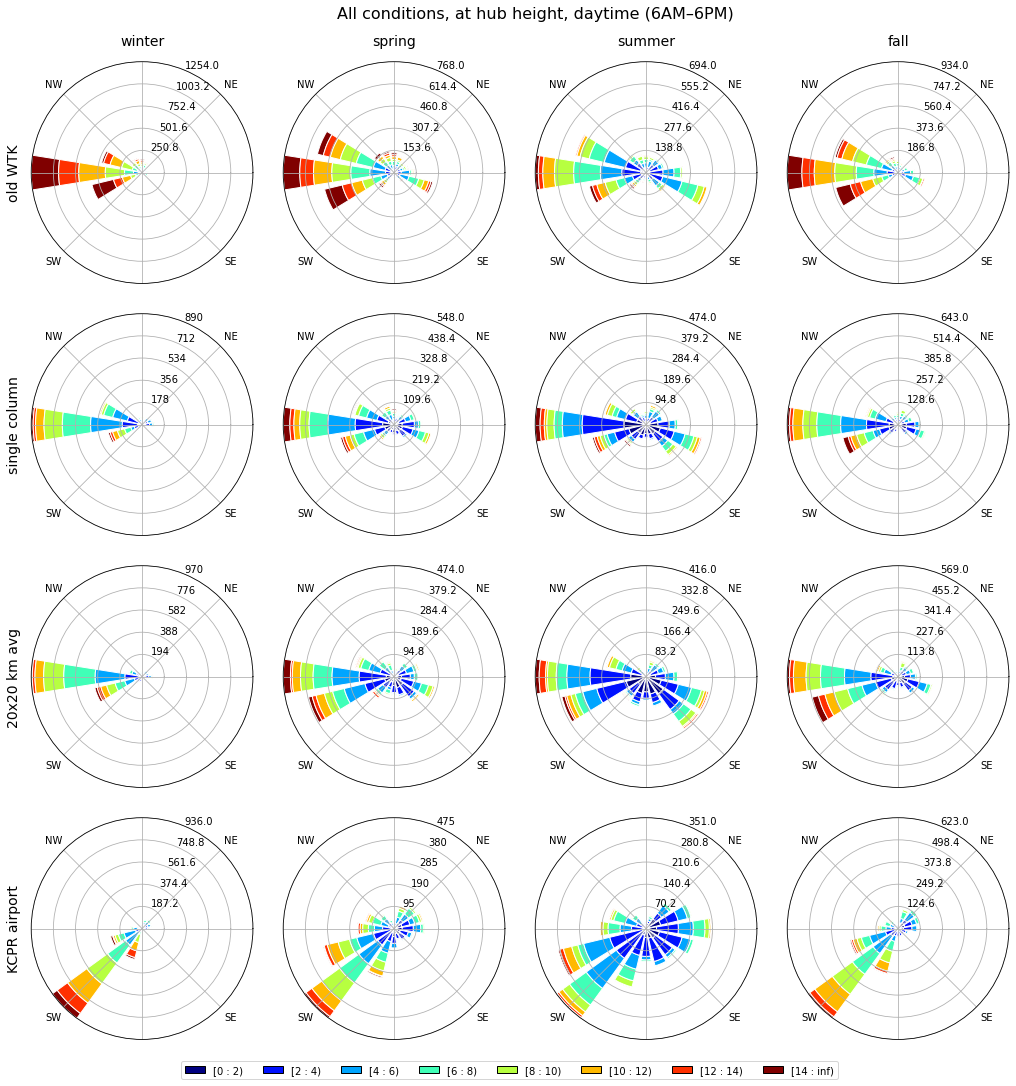

In [53]:
# Daytime, all conditions
fig = plt.figure(figsize=(14,14))
fig.suptitle('All conditions, at hub height, daytime (6AM–6PM)', y=1.025, fontsize=16)

for d,df in enumerate([dfold,dfsc,df20km,dfcasp]):
    for s in range(4):
        wa = wr.WindroseAxes(fig, rec4x4[d*4+s])
        fig.add_axes(wa)
        if d==3: data = dfcasp.loc[(dfcasp['season']==s) & (dfcasp['hour']>=6) & (dfcasp['hour']<18)]
        else:    data = df.loc[(df['season']==s) & (df['hour']>=6) & (df['hour']<18)].xs(zhub, level='height') 
        ws = data['windspeed'].values
        wd = data['winddirection'].values   
        wa.bar(wd, ws, bins=bins, opening=0.8, edgecolor='white')
        wa.set_xticklabels(wrlabels)
        if d==0: wa.set_title(f'{season_names[s]}',fontsize=14, y=1.05)
        if s==0: wa.set_ylabel(f'{dfnames[d]}', fontsize=14, labelpad=10)

wa.legend(loc='lower right',decimal_places=0,labelspacing=0.7,bbox_to_anchor=(0.25,-0.2),ncol=len(bins))

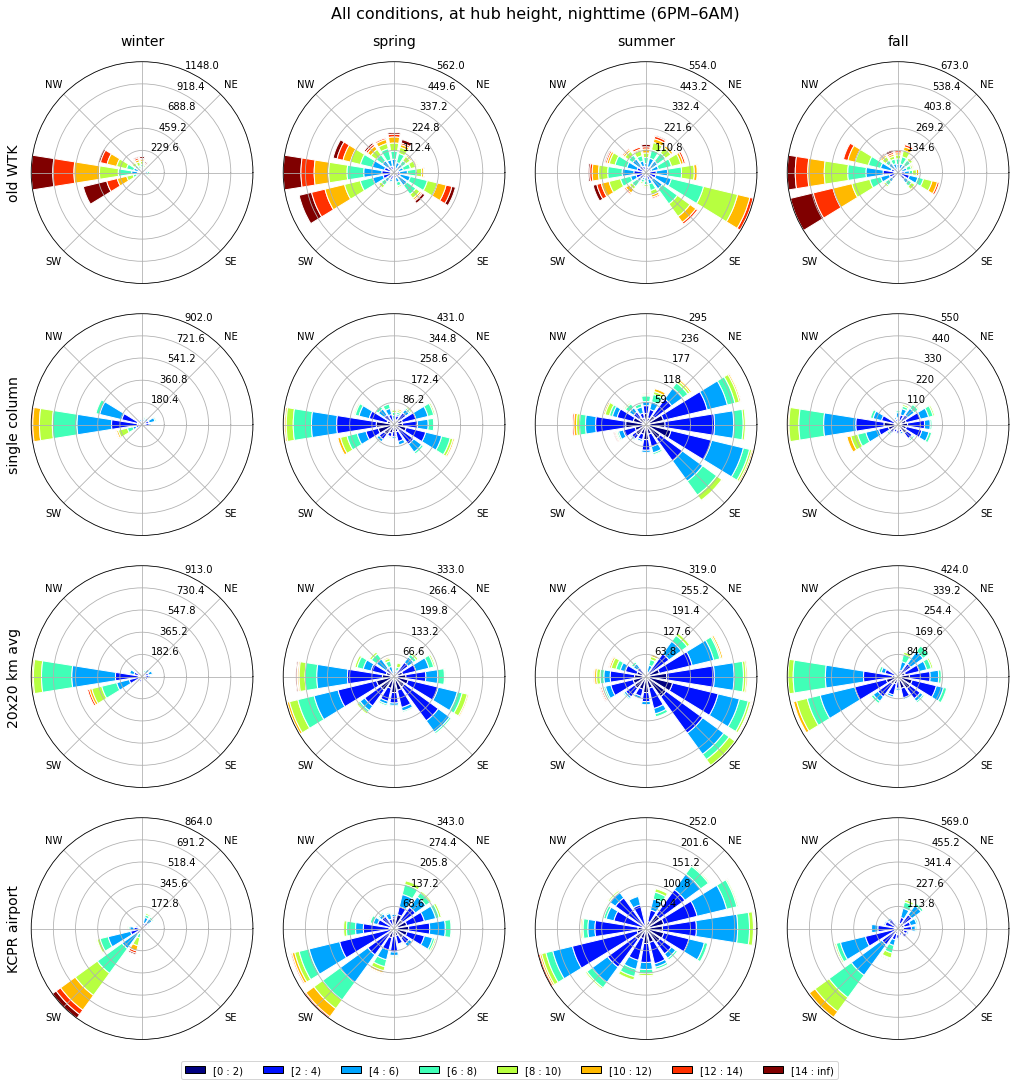

In [54]:
# Nighttime, all conditions
fig = plt.figure(figsize=(14,14))
fig.suptitle('All conditions, at hub height, nighttime (6PM–6AM)', y=1.025, fontsize=16)

for d,df in enumerate([dfold,dfsc,df20km,dfcasp]):
    for s in range(4):
        wa = wr.WindroseAxes(fig, rec4x4[d*4+s])
        fig.add_axes(wa)
        if d==3: data = dfcasp.loc[(dfcasp['season']==s) & ((dfcasp['hour']<6) | (dfcasp['hour']>=18))]
        else:    data = df.loc[(df['season']==s) & ((df['hour']<6) | (df['hour']>=18))].xs(zhub, level='height')  
        ws = data['windspeed'].values
        wd = data['winddirection'].values   
        wa.bar(wd, ws, bins=bins, opening=0.8, edgecolor='white')
        wa.set_xticklabels(wrlabels)
        if d==0: wa.set_title(f'{season_names[s]}',fontsize=14, y=1.05)
        if s==0: wa.set_ylabel(f'{dfnames[d]}', fontsize=14, labelpad=10)

wa.legend(loc='lower right',decimal_places=0,labelspacing=0.7,bbox_to_anchor=(0.25,-0.2),ncol=len(bins))

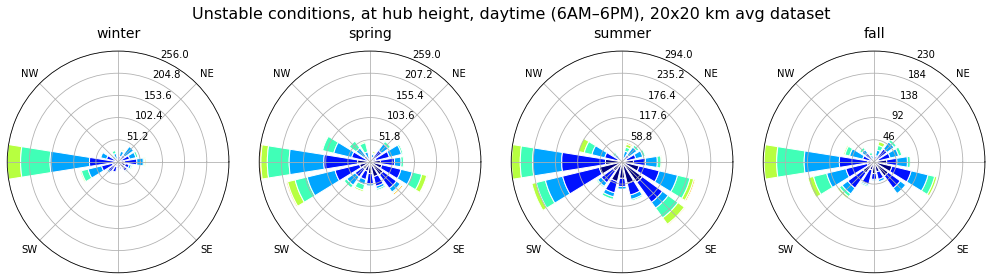

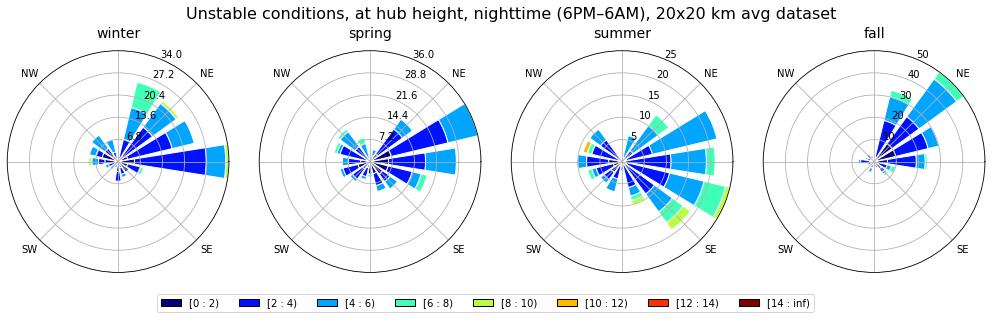

In [55]:
# Unstable conditions, 20x20 dataset
fig = plt.figure(figsize=(14,5))
fig.suptitle('Unstable conditions, at hub height, daytime (6AM–6PM), 20x20 km avg dataset', y=0.93, fontsize=16)

df=df20km

for s in range(4):
    wa = wr.WindroseAxes(fig, rec4x1[s])
    fig.add_axes(wa)
    cond = ((df['season']==s) & (df['hour']>=6) & (df['hour']<18) & ((df['stability']=='U')|(df['stability']=='VU')))
    ws = df.loc[cond].xs(zhub, level='height')['windspeed'].values
    wd = df.loc[cond].xs(zhub, level='height')['winddirection'].values   
    wa.bar(wd, ws, bins=bins, opening=0.8, edgecolor='white')
    wa.set_xticklabels(wrlabels)
    wa.set_title(f'{season_names[s]}',fontsize=14, y=1.03)
plt.show()
print('\n\n')

fig = plt.figure(figsize=(14,5))
fig.suptitle('Unstable conditions, at hub height, nighttime (6PM–6AM), 20x20 km avg dataset', y=0.93, fontsize=16)
for s in range(4):
    wa = wr.WindroseAxes(fig, rec4x1[s])
    fig.add_axes(wa)
    cond = ((df['season']==s) & ((df['hour']<6)|(df['hour']>=18)) & ((df['stability']=='U')|(df['stability']=='VU')))
    ws = df.loc[cond].xs(zhub, level='height')['windspeed'].values
    wd = df.loc[cond].xs(zhub, level='height')['winddirection'].values   
    wa.bar(wd, ws, bins=bins, opening=0.8, edgecolor='white')
    wa.set_xticklabels(wrlabels)
    wa.set_title(f'{season_names[s]}',fontsize=14, y=1.03)
    
wa.legend(loc='lower right',decimal_places=0,labelspacing=0.7,bbox_to_anchor=(0.25,-0.2),ncol=len(bins))
plt.show()

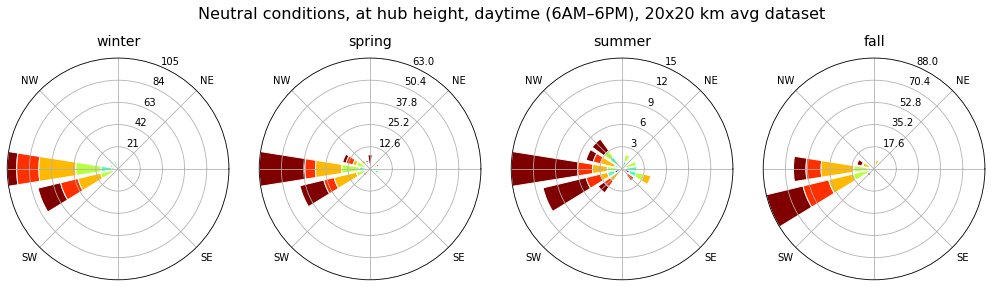

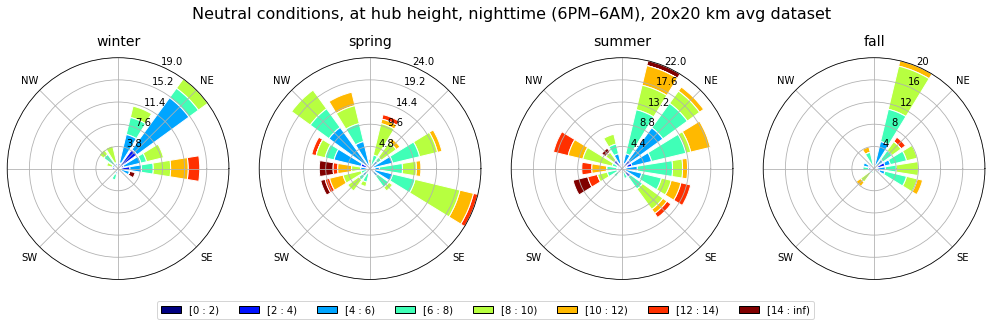

In [56]:
# Neutral conditions, 20x20 dataset
fig = plt.figure(figsize=(14,5))
fig.suptitle('Neutral conditions, at hub height, daytime (6AM–6PM), 20x20 km avg dataset', y=0.95, fontsize=16)

df=df20km

for s in range(4):
    wa = wr.WindroseAxes(fig, rec4x1[s])
    fig.add_axes(wa)
    cond = ((df['season']==s) & (df['hour']>=6) & (df['hour']<18) & (df['stability']=='N'))
    ws = df.loc[cond].xs(zhub, level='height')['windspeed'].values
    wd = df.loc[cond].xs(zhub, level='height')['winddirection'].values   
    wa.bar(wd, ws, bins=bins, opening=0.8, edgecolor='white')
    wa.set_xticklabels(wrlabels)
    wa.set_title(f'{season_names[s]}',fontsize=14, y=1.03)
plt.show()
print('\n\n')

fig = plt.figure(figsize=(14,5))
fig.suptitle('Neutral conditions, at hub height, nighttime (6PM–6AM), 20x20 km avg dataset', y=0.95, fontsize=16)
for s in range(4):
    wa = wr.WindroseAxes(fig, rec4x1[s])
    fig.add_axes(wa)
    cond = ((df['season']==s) & ((df['hour']<6)|(df['hour']>=18)) & (df['stability']=='N'))
    ws = df.loc[cond].xs(zhub, level='height')['windspeed'].values
    wd = df.loc[cond].xs(zhub, level='height')['winddirection'].values   
    wa.bar(wd, ws, bins=bins, opening=0.8, edgecolor='white')
    wa.set_xticklabels(wrlabels)
    wa.set_title(f'{season_names[s]}',fontsize=14, y=1.03)
    
wa.legend(loc='lower right',decimal_places=0,labelspacing=0.7,bbox_to_anchor=(0.25,-0.2),ncol=len(bins))
plt.show()

### 5.5. Heat flux on selected scenarios

In [57]:
# Copy wind direction info from zhub to 0m so it's easier to slice/loc dataframe with hfx information
df20km.loc[(slice(None),0),'dir'] = df20km.xs(zhub, level='height')['dir'].values

Text(0.5, 1.0, 'heat flux: W winds, U/VU states, Daytime, 20x20 km dataset')

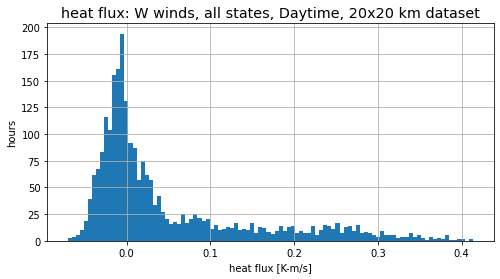

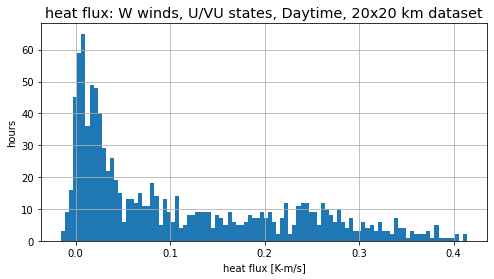

In [58]:
# heat flux, all states, W winds only
cond = ((df20km['dir']=='W') & (df20km['hour']>=6) & (df20km['hour']<18))
heatflux = df20km.loc[cond]['hfx_Kms'].xs(0,level='height')
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,4))
ax = heatflux.hist(bins=100)
ax.set_xlabel('heat flux [K-m/s]')
ax.set_ylabel('hours')
ax.set_title(r'heat flux: W winds, all states, Daytime, 20x20 km dataset', fontsize='x-large')

# heat flux, U/VU states
cond = (df20km['dir']=='W') & (df20km['hour']>=6) & (df20km['hour']<18) & ((df20km['stability']=='U')|(df20km['stability']=='VU'))
heatflux = df20km.loc[cond]['hfx_Kms'].xs(0,level='height')
#heatflux = df['hfx_kms'].loc[(df['stability']=='U') | (df['stability']=='VU')].xs(0,level='height')
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,4))
ax = heatflux.hist(bins=100)
ax.set_xlabel('heat flux [K-m/s]')
ax.set_ylabel('hours')
ax.set_title(r'heat flux: W winds, U/VU states, Daytime, 20x20 km dataset', fontsize='x-large')